In [1]:
from lr.models.transformers.processor import filter_df_by_label
from lr.models.transformers.BertWrapper import BertWrapper
from lr.stats.h_testing import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import shutil
import os

### Params

In [2]:
folder = "snli"

hyperparams = {"local_rank": -1,
               "max_seq_length": 200,
               "overwrite_cache": False,
               "num_train_epochs": 1.0,
               "per_gpu_train_batch_size": 32,
               "per_gpu_eval_batch_size": 300,
               "gradient_accumulation_steps": 1,
               "learning_rate": 5e-5,
               "weight_decay": 0.0,
               "adam_epsilon": 1e-8,
               "max_grad_norm": 1.0,
               "max_steps": 1200,
               "warmup_steps": 0,
               "save_steps": 100,
               "no_cuda": False,
               "n_gpu": 1,
               "model_name_or_path": "bert",
               "output_dir": "bert",
               "random_state": 42,
               "fp16": False,
               "fp16_opt_level": "01",
               "device": "cpu",
               "verbose": True,
               "model_type": "bert",
               "pad_on_left": False,
               "pad_token": 0,
               "n_cores": 7,
               "pad_token_segment_id": 0,
               "mask_padding_with_zero": True,
               "base_path": "data/{}/cached_".format(folder)}

# loading trainded models

In [8]:
my_bert = BertWrapper(hyperparams)
path = "saved_models/bert/checkpoint-1200"
my_bert.load(path)

param_count = my_bert.get_param_count()
print("Bert, total number of parameters = {}".format(param_count))

Bert, total number of parameters = 109484547


## Loading DFs

In [4]:
dev = pd.read_csv("data/snli/dev.csv")
dev_t = pd.read_csv("data/snli/dev_p_h_syn_noun.csv")

## Eval

In [5]:
r_path = "results/snli/bert/naive_results.csv"
if not os.path.exists("results/snli/bert/naive_results.csv"):

    init = time()
    dev_results = my_bert.get_results(dev, mode="test")

    dev_t_results = my_bert.get_results(dev_t, mode="test_transformed")
    eval_time = time() - init
    print("eval time = ", eval_time)

    m_results = get_matched_results_transformers(dev_results,dev_t_results)
    m_results.to_csv(r_path, index=False)

else:
    m_results = pd.read_csv(r_path)

## Results
### Accuracy

In [6]:
print("A = {:.5%} | B = {:.5%}".format(m_results.A.mean(), m_results.B.mean()))

A = 84.75920% | B = 80.77626%


### Hypothesis test

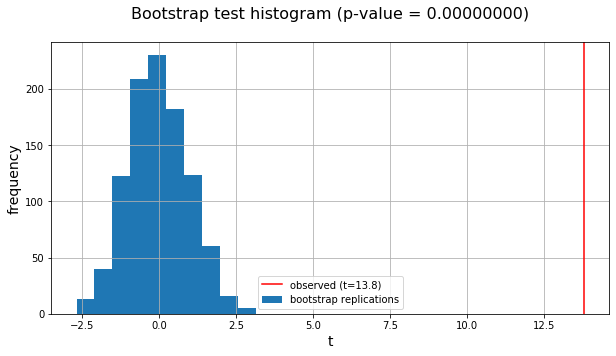

In [7]:
S = 1000
t_obs = get_paired_t_statistic(m_results)

# Generate S bootstrap replications
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(m_results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

# Get bootstrap p-value
t_boots = pd.Series(t_boots)
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed (t={:.1f})".format(t_obs));
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");